Deconvolution Microscopy
========================

This example partially replicates a [GlobalBioIm example](https://biomedical-imaging-group.github.io/GlobalBioIm/examples.html) using the [microscopy data](http://bigwww.epfl.ch/deconvolution/bio/) provided by the EPFL Biomedical Imaging Group.

The deconvolution problem is solved using class [admm.ADMM](../_autosummary/scico.admm.rst#scico.admm.ADMM) to solve an image deconvolution problem with isotropic total variation (TV) regularization.

  $$\mathrm{argmin}_{\mathbf{x}} \; \| M (\mathbf{y} - A \mathbf{x}) \|_2^2 + \lambda \| C \mathbf{x} \|_{2,1} + \iota_{\mathrm{NN}}(\mathbf{x}) \;,$$

where $M$ is a mask operator, $A$ is circular convolution, $\mathbf{y}$ is the blurred image, $C$ is a convolutional gradient operator, $\iota_{mathrm{NN}}$ is the indicator function of the non-negativity constraint, and $\mathbf{x}$ is the desired image.

In [1]:
import glob
import os
import tempfile
import zipfile

import numpy as np

import imageio

import scico.numpy as snp
from scico import functional, linop, loss, plot, util
from scico.admm import ADMM, CircularConvolveSolver
plot.config_notebook_plotting()

Define helper functions.

In [2]:
def volread(path, ext="tif"):
    """Read a 3D volume from a set of files in the specified directory"""

    slices = []
    for file in sorted(glob.glob(os.path.join(path, "*." + ext))):
        image = imageio.imread(file)
        slices.append(image)
    return np.dstack(slices)


def block_avg(im, N):
    """
    Average distinct NxNxN blocks of im, return the resulting smaller image
    """

    im = snp.mean(snp.reshape(im, (-1, N, im.shape[1], im.shape[2])), axis=1)
    im = snp.mean(snp.reshape(im, (im.shape[0], -1, N, im.shape[2])), axis=2)
    im = snp.mean(snp.reshape(im, (im.shape[0], im.shape[1], -1, N)), axis=3)

    return im

Download data or access it from cache directory.

In [3]:
data_base_url = "http://bigwww.epfl.ch/deconvolution/bio/"
data_zip_files = ["CElegans-CY3.zip", "CElegans-DAPI.zip", "CElegans-FITC.zip"]
psf_zip_files = ["PSF-CElegans-CY3.zip", "PSF-CElegans-DAPI.zip", "PSF-CElegans-FITC.zip"]
cache_path = os.path.join(os.path.expanduser("~"), ".cache", "scico", "epfl_big")
if not os.path.isdir(cache_path):
    os.makedirs(cache_path)
    temp_dir = tempfile.TemporaryDirectory()
    for zip_file in data_zip_files + psf_zip_files:
        data = util.url_get(data_base_url + zip_file)
        f = open(os.path.join(temp_dir.name, zip_file), "wb")
        f.write(data.read())
        f.close()
    for zip_file in data_zip_files + psf_zip_files:
        with zipfile.ZipFile(os.path.join(temp_dir.name, zip_file), "r") as zip_ref:
            zip_ref.extractall(cache_path)

image_list = []
for zip_file in data_zip_files:
    image_list.append(volread(os.path.join(cache_path, zip_file[:-4])).astype(np.float32))
y = snp.stack(image_list)
del image_list
psf_list = []
for zip_file in psf_zip_files:
    psf_list.append(volread(os.path.join(cache_path, zip_file[:-4])).astype(np.float32))
psf = snp.stack(psf_list)
del psf_list

Preprocess data. We downsample by a factor of 4 for purposes of the example.
Reducing the downsampling rate will be slower and more memory-intensive.
If your GPU does not have enough memory, you can try setting the environment
variable `JAX_PLATFORM_NAME=cpu` to run on CPU.

In [4]:
channel = 0
downsampling_rate = 4

y = block_avg(y[channel], downsampling_rate)
psf = block_avg(psf[channel], downsampling_rate)


y -= y.min()
y /= y.max()

psf /= psf.sum()

Pad data and create mask.

In [5]:
padding = [[0, p] for p in snp.array(psf.shape) - 1]
y_pad = snp.pad(y, padding)
mask = snp.pad(snp.ones_like(y), padding)

Define problem and algorithm parameters.

In [6]:
λ = 2e-6  # L1 norm regularization parameter
ρ0 = 1e-3  # ADMM penalty parameter for first auxiiary variable
ρ1 = 1e-3  # ADMM penalty parameter for second auxiiary variable
ρ2 = 1e-3  # ADMM penalty parameter for third auxiiary variable
maxiter = 100  # Number of ADMM iterations

Create operators.

In [7]:
M = linop.Diagonal(mask)
C0 = linop.CircularConvolve(h=psf, input_shape=mask.shape, h_center=snp.array(psf.shape) / 2 - 0.5)
C1 = linop.FiniteDifference(input_shape=mask.shape, circular=True)
C2 = linop.Identity(mask.shape)

Create functionals.

In [8]:
g0 = loss.SquaredL2Loss(y=y_pad, A=M)  # Loss function (forward model)
g1 = λ * functional.L21Norm()  # TV penalty (when applied to gradient)
g2 = functional.NonNegativeIndicator()  # Non-negativity constraint

Set up ADMM solver object and solve problem.

In [9]:
##
solver = ADMM(
    f=None,
    g_list=[g0, g1, g2],
    C_list=[C0, C1, C2],
    rho_list=[ρ0, ρ1, ρ2],
    maxiter=maxiter,
    verbose=True,
    x0=y_pad,
    subproblem_solver=CircularConvolveSolver(),
)

t = util.Timer()
with util.ContextTimer(t):
    solver.solve()
solve_stats = solver.itstat_object.history(transpose=True)
x_pad = solver.x
x = x_pad[: y.shape[0], : y.shape[1], : y.shape[2]]

##

Iter  Objective  Primal Rsdl  Dual Rsdl
---------------------------------------
   0  6.897e-02    1.059e+02  7.430e+01
   1  8.898e-02    5.572e+01  8.752e+01
   2  1.058e-01    5.023e+01  7.186e+01
   3  1.189e-01    6.156e+01  4.522e+01
   4  1.333e-01    5.683e+01  3.635e+01
   5  1.500e-01    4.092e+01  4.393e+01
   6  1.661e-01    2.699e+01  4.704e+01
   7  1.815e-01    2.281e+01  4.420e+01
   8  1.964e-01    2.341e+01  4.018e+01
   9  2.101e-01    2.199e+01  3.820e+01
  10  2.219e-01    2.021e+01  3.712e+01
  11  2.313e-01    2.144e+01  3.495e+01
  12  2.383e-01    2.500e+01  3.141e+01
  13  2.430e-01    2.850e+01  2.733e+01
  14  2.459e-01    3.101e+01  2.348e+01
  15  2.473e-01    3.256e+01  2.014e+01
  16  2.475e-01    3.334e+01  1.746e+01
  17  2.468e-01    3.339e+01  1.576e+01
  18  2.456e-01    3.270e+01  1.544e+01
  19  2.438e-01    3.133e+01  1.642e+01
  20  2.419e-01    2.942e+01  1.812e+01
  21  2.399e-01    2.710e+01  2.007e+01
  22  2.381e-01    2.446e+01  2.196e+01


Show the recovered image.

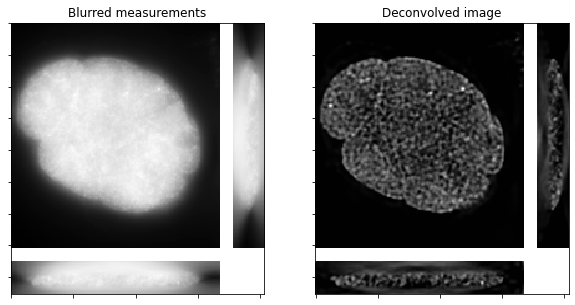

In [10]:
def make_slices(x, sep_width=10):
    """
    Make an image with xy, xz, and yz slices from an input volume.
    """
    fill_val = -1.0
    out = snp.concatenate(
        (
            x[:, :, x.shape[2] // 2],
            snp.full((x.shape[0], sep_width), fill_val),
            x[:, x.shape[1] // 2, :],
        ),
        axis=1,
    )

    out = snp.concatenate(
        (
            out,
            snp.full((sep_width, out.shape[1]), fill_val),
            snp.concatenate(
                (
                    x[x.shape[0] // 2, :, :].T,
                    snp.full((x.shape[2], x.shape[2] + sep_width), fill_val),
                ),
                axis=1,
            ),
        ),
        axis=0,
    )

    out = snp.where(out == fill_val, out.max(), out)

    return out


fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(10, 5))
plot.imview(make_slices(y), title="Blurred measurements", fig=fig, ax=ax[0])
plot.imview(make_slices(x), title="Deconvolved image", fig=fig, ax=ax[1])
fig.show()

Plot convergence statistics.

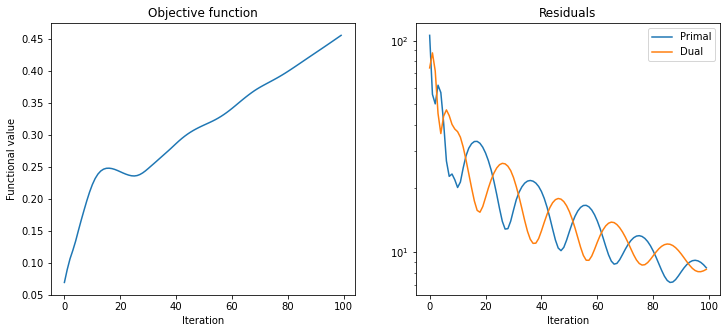

In [11]:
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 5))
plot.plot(
    solve_stats.Objective,
    title="Objective function",
    xlbl="Iteration",
    ylbl="Functional value",
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack((solve_stats.Primal_Rsdl, solve_stats.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
    fig=fig,
    ax=ax[1],
)
fig.show()